In [ ]:
# please use data_viz1 as your environment. data_viz0 is having some problems.

In [2]:
import dill
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral

import mdtraj as md

import matplotlib.pyplot as plt
from collections import Counter

import os

**First Order of Business:** let's see if our conditioning consistantly picked the correct loss strategy

In [4]:
strategies_batches = [
    f'/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_losses_selected_batch-{i}.pkl' for i in range(4)
]

strategies_list = []

for batch_str in strategies_batches:
    # Load from the file
    with open(batch_str, "rb") as f:
        loaded_list = dill.load(f)
    
    for j in loaded_list:
        strategies_list.append(j)

In [5]:
count = 0

for i in strategies_list:
    if i == strategies_list[0]:
        count += 1

print(count) # per the below output, it picked the correct outcome every single time.

400


**Nice! Now onto next objective:** We want to do PCA on the dihedral angles, maybe bond angles, on the generated samples, and compare where they lie in this PCA space to the raw validation data.

In [3]:
def generate_mdtraj_trajectory(pdb_path, data_files, print_shape = False):
    """
    Loads a PDB file, infers bonds, processes NPZ and NPY files, and constructs an MDTraj trajectory.

    Parameters:
        pdb_path (str): Path to the PDB file.
        data_files (list of str): List of paths to NPZ or NPY files containing sampled atomic positions.

    Returns:
        mdtraj.Trajectory: The generated trajectory with inferred bonds and centered coordinates.
    """

    # Load PDB and infer bonds
    pdb = md.load(pdb_path)
    pdb.topology.create_standard_bonds()  # Infer bonds based on atom types and residue connectivity
    topology = pdb.topology

    # Load and process generated samples
    all_samples = []
    for data_file in data_files:
        file_extension = os.path.splitext(data_file)[1]

        if file_extension == ".npz":
            data = np.load(data_file)
            samples_np = data["samples_np"]  # Extract the relevant array from NPZ
        elif file_extension == ".npy":
            samples_np = np.load(data_file)  # Load directly from NPY
        else:
            raise ValueError(f"Unsupported file format: {data_file}")

        # Reshape samples to match the number of atoms in the PDB
        n_atoms = len(list(topology.atoms))
        samples = samples_np.reshape(-1, n_atoms, 3)  # (n_frames, n_atoms, 3)
        all_samples.append(samples)

    # Combine all samples into a single array
    all_samples = np.concatenate(all_samples, axis=0)
    if print_shape:
        print(all_samples.shape)

    # Create an MDTraj trajectory with the inferred bonds
    traj = md.Trajectory(
        xyz=all_samples,  # Shape: (n_frames, n_atoms, 3)
        topology=topology
    )

    # Center the trajectory around the origin
    traj.center_coordinates()

    return traj

def compute_all_dihedrals(traj):
    """
    Computes backbone (phi, psi, omega) and side-chain (chi1, chi2, chi3, chi4) dihedral angles 
    for all amino acids in the given trajectory.
    
    Parameters:
        traj (mdtraj.Trajectory): MDTraj trajectory object.
    
    Returns:
        dict: Dictionary containing dihedral angles in degrees.
    """

    # Compute backbone dihedral angles
    phi_indices, phi_angles = md.compute_phi(traj)
    psi_indices, psi_angles = md.compute_psi(traj)
    omega_indices, omega_angles = md.compute_omega(traj)

    # Compute side-chain chi angles (some may be empty depending on the peptide)
    chi1_indices, chi1_angles = md.compute_chi1(traj)
    chi2_indices, chi2_angles = md.compute_chi2(traj)
    chi3_indices, chi3_angles = md.compute_chi3(traj)
    chi4_indices, chi4_angles = md.compute_chi4(traj)

    dihedral_angles = {
        "phi": phi_angles,
        "psi": psi_angles,
        "omega": omega_angles,
        "chi1": chi1_angles if chi1_angles.size else None,
        "chi2": chi2_angles if chi2_angles.size else None,
        "chi3": chi3_angles if chi3_angles.size else None,
        "chi4": chi4_angles if chi4_angles.size else None,
    }

    return dihedral_angles

def concat_dihedrals(dihedrals_dict):
    # Concatenate along axis=1 to preserve n_samples while summing the second dimension
    all_dihedrals = np.concatenate([
        dihedrals_dict['phi'],   
        dihedrals_dict['omega'], 
        dihedrals_dict['psi'],   
        dihedrals_dict['chi1'],  
        dihedrals_dict['chi2'],  
        dihedrals_dict['chi3']
    ], axis=1) # shape should be (n_samples, n_dihedrals)

    return all_dihedrals

################################################################
# unfortunately, I couldn't get sklearn to work in this env.
# therefore, I have just had chat GPT implement PCA in numpy
# Thanks, Chat GPT :)
################################################################

def pca_numpy(data, n_components: int):
    """
    Perform PCA using NumPy's eigenvalue decomposition.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        n_components (int): Number of principal components to keep.

    Returns:
        principal_components (numpy.ndarray): The principal component vectors (n_features, n_components).
        explained_variance (numpy.ndarray): Explained variance ratio of each principal component.
    """
    # Center the data
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # Compute covariance matrix
    covariance_matrix = np.cov(data_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]  # Sorted eigenvalues
    eigenvectors = eigenvectors[:, sorted_indices]  # Sorted eigenvectors

    # Compute explained variance ratio
    explained_variance = eigenvalues[:n_components] / np.sum(eigenvalues)

    # Select the top 'n_components' eigenvectors
    principal_components = eigenvectors[:, :n_components]

    return principal_components, explained_variance

def project_data(data, principal_components, center = False):
    """
    Projects data onto the given principal components.

    Parameters:
        data (numpy.ndarray): Input data of shape (n_samples, n_features).
        principal_components (numpy.ndarray): Principal components of shape (n_components, n_features).

    Returns:
        projected_data (numpy.ndarray): Data projected onto principal components of shape (n_samples, n_components).
    """
    # Center the data
    if center:
        data_mean = np.mean(data, axis=0)
        data_centered = data - data_mean
    else:
        data_centered = data

    # Compute projection: dot product with principal components
    projected_data = np.dot(data_centered, principal_components.T)  # Shape: (n_samples, n_components)

    return projected_data

def plot_pca_scatter(projected_data, alpha=0.5, s=2, color="blue"):
    """
    Plots PCA-projected data in 2D space.

    Parameters:
        projected_data (numpy.ndarray): Shape (n_samples, 2), each row is a point in PCA space.
        alpha (float): Transparency of points (default 0.5).
        s (int): Size of points (default 2).
        color (str): Color of points (default "blue").
    
    Returns:
        None (displays plot).
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=alpha, s=s, color=color)
    
    # Formatting
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection of Data")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Add horizontal axis
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Add vertical axis
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Show plot
    plt.show()

**First Test:** We will compare where the conditionally generated samples lie in PCA space compared to the validation data

In [4]:
traj = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                  data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',
                                                '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy',
                                                ],)
dihedrals_dict = compute_all_dihedrals(traj)
all_dihedrals = concat_dihedrals(dihedrals_dict) # we will use this to determine our PCA axes



traj_conditional = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                              data_files = ['/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-0.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-1.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-2.npz',
                                                            '/home/bfd21/rds/hpc-work/tbg/cyclization/jobs/l1-sample-Feb-13/conditioned-on-cyc/uncond-on-time/cond-cyc-unc-time-l1-inference_batch-3.npz',],)
dihedrals_dict_conditional = compute_all_dihedrals(traj_conditional)
conditional_dihedrals = concat_dihedrals(dihedrals_dict_conditional) # contains just the conditionally generated dihedrals

traj_raw = generate_mdtraj_trajectory(pdb_path = '/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/ligand1.pdb', 
                                      data_files= ['/home/bfd21/rds/hpc-work/data/MDM2-sample-binders/ligand-only/l1/splits/l1_val.npy'])
dihedrals_dict_raw = compute_all_dihedrals(traj_raw)
raw_dihedrals = concat_dihedrals(dihedrals_dict_raw) # contains just the raw generated dihedrals

In [17]:
# Axes yielded by PCA analysis, which we will project out data onto.
pcs=[pca_numpy(all_dihedrals, 2)[0][:, i] for i in range(2)]
pcs_arr = np.array(pcs) # (n_components, n_features)

proj_raw = project_data(np.array(raw_dihedrals), pcs_arr) # (n_samples, n_features)
proj_cond = project_data(np.array(conditional_dihedrals), pcs_arr)

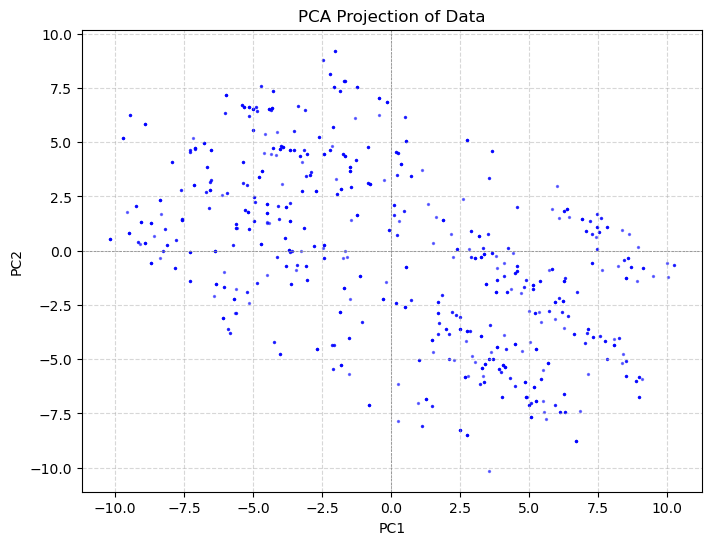

In [18]:
plot_pca_scatter(proj_cond)

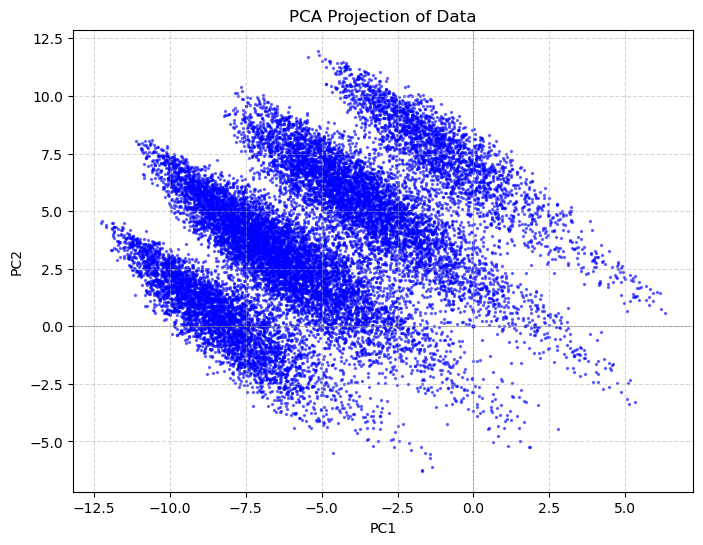

In [19]:
plot_pca_scatter(proj_raw)

**Second Test:** We will compare where the conditionally generated samples lie vs. the unconditionally generated ones

**Third Test:** We will compare the conditional and unconditional to the raw data in PCA space